# <ins>C</ins>onformal <ins>Re</ins>gressors and <ins>P</ins>r<ins>e</ins>dictive <ins>S</ins>ystems (crepes)

Author: Henrik Boström (bostromh@kth.se)  
Copyright 2022 Henrik Boström  
License: BSD 3 clause

### 1. Import packages, data and train an underlying model

#### 1.1 Import packages

In the examples below, we will be using `NumPy`, `pandas`, `matplotlib` and `sklearn`. From `crepes`, we import the two main classes `ConformalRegressor` and `ConformalPredictiveSystem`, while we import some helper functions from `crepes.fillings`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

from crepes import ConformalRegressor, ConformalPredictiveSystem

from crepes.fillings import (sigma_variance, 
                             sigma_variance_oob,
                             sigma_knn,
                             binning)

#### 1.2 Import data and train a model

Let us import a dataset from www.openml.org and min-max normalize the targets; the latter is not really necessary, but useful, allowing to directly compare the size of a prediction interval to the whole target range, which becomes 1 in this case.

In [2]:
dataset = fetch_openml(name="house_sales",version=3)

X = dataset.data.values.astype(float)
y = dataset.target.values.astype(float)

y = np.array([(y[i]-y.min())/(y.max()-y.min()) for i in range(len(y))])

We now split the dataset into a training and a test set, and further split the training set into a proper training set and a calibration set. Let us fit a random forest to the proper training set. We also set a random seed to be able to rerun the notebook and get the same results.

In [3]:
np.random.seed(602211023)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train,
                                                            test_size=0.25)

learner_prop = RandomForestRegressor(n_jobs=-1, n_estimators=500) 

learner_prop.fit(X_prop_train, y_prop_train)

RandomForestRegressor(n_estimators=500, n_jobs=-1)

### 2. Conformal regressors (CR)

#### 2.1 Standard conformal regressors

Let us create a conformal regressor.

In [4]:
cr_std = ConformalRegressor()

We may display the object, e.g., to see whether it has been fitted or not.

In [5]:
display(cr_std)

ConformalRegressor(fitted=False)

We will use the residuals from the calibration set to fit the conformal regressor. 

In [6]:
y_hat_cal = learner_prop.predict(X_cal)

residuals_cal = y_cal - y_hat_cal

cr_std.fit(residuals=residuals_cal)

ConformalRegressor(fitted=True, normalized=False, mondrian=False)

We may now obtain prediction intervals from the point predictions for the test set; 
here using a confidence level of 99%.

In [7]:
y_hat_test = learner_prop.predict(X_test)

intervals = cr_std.predict(y_hat=y_hat_test, confidence=0.99)

display(intervals)

array([[-0.03201615,  0.11384434],
       [-0.04521853,  0.10064197],
       [-0.00424899,  0.14161151],
       ...,
       [ 0.02452438,  0.17038488],
       [-0.04886076,  0.09699974],
       [-0.03928885,  0.10657165]])

We may request that the intervals are cut to exclude impossible values, in this case below 0 and above 1; below we also use the default 
confidence level (95%), which further tightens the intervals.

In [8]:
intervals_std = cr_std.predict(y_hat=y_hat_test, y_min=0, y_max=1)

display(intervals_std)

array([[0.01106069, 0.0707675 ],
       [0.        , 0.05756512],
       [0.03882786, 0.09853466],
       ...,
       [0.06760123, 0.12730803],
       [0.        , 0.05392289],
       [0.003788  , 0.0634948 ]])

#### 2.2 Normalized conformal regressors

The above intervals are not normalized, i.e., they are all of the same size (at least before they are cut). We could make the intervals more informative through normalization using difficulty estimates; 
more difficult instances will be assigned wider intervals. We can use the helper function `sigma_knn` for this purpose. It estimates the difficulty by the mean absolute errors of the k nearest neighbors to each instance in the calibration set. A small value (beta) is added to the estimates, which may be given through a (named) argument to the function; below we just use the default, i.e., `beta=0.01`.

In [9]:
sigmas_cal_knn = sigma_knn(X=X_cal, residuals=residuals_cal)

cr_norm_knn = ConformalRegressor()

cr_norm_knn.fit(residuals=residuals_cal, sigmas=sigmas_cal_knn)

display(cr_norm_knn)

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

To generate prediction intervals for the test set, we need difficulty estimates for the latter too, which we get using the calibration objects and residuals. 

In [10]:
sigmas_test_knn = sigma_knn(X=X_cal, residuals=residuals_cal, X_test=X_test)

intervals_norm_knn = cr_norm_knn.predict(y_hat=y_hat_test, 
                                         sigmas=sigmas_test_knn,
                                         y_min=0, y_max=1)

display(intervals_norm_knn)

array([[0.02213197, 0.05969621],
       [0.00490446, 0.05051898],
       [0.03095047, 0.10641205],
       ...,
       [0.04670171, 0.14820755],
       [0.0012564 , 0.04688257],
       [0.0084359 , 0.0588469 ]])

In case we have trained an ensemble model, like a `RandomForestRegressor`, we could alternatively use the helper function `sigma_variance`, which estimates the difficulty by the variance of the predictions of the constituent models. The function requires the trained model `learner` to be provided as input, assuming that `learner.estimators_` is a collection of base models, each implementing the `predict` method; this holds e.g., for `RandomForestRegressor`. Note that in contrast to `sigma_knn`, the residuals are not used for difficulty estimation here.

In [11]:
sigmas_cal_var = sigma_variance(X=X_cal, learner=learner_prop)

cr_norm_var = ConformalRegressor()

cr_norm_var.fit(residuals=residuals_cal, sigmas=sigmas_cal_var)

display(cr_norm_var)

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

The difficulty estimates for the test set are generated in the same way; they are needed to generate the normalized prediction intervals.

In [12]:
sigmas_test_var = sigma_variance(X=X_test, learner=learner_prop)

intervals_norm_var = cr_norm_var.predict(y_hat=y_hat_test, 
                                         sigmas=sigmas_test_var, 
                                         y_min=0, y_max=1)

display(intervals_norm_var)

array([[0.01393936, 0.06788882],
       [0.00069462, 0.05472882],
       [0.04112209, 0.09624044],
       ...,
       [0.07009253, 0.12481673],
       [0.        , 0.05101747],
       [0.00658782, 0.06069498]])

#### 2.3 Mondrian conformal regressors

An alternative way of generating prediction intervals of varying size
is to divide the object space into non-overlapping so-called Mondrian categories.
A Mondrian conformal regressor is formed by providing the names of the categories
as an additional argument, named `bins`, for the `fit` method.

Here we employ the helper function `binning`, which given a list/array of values
returns an array of the same length with the assigned bins. If the optional argument `bins` is an
integer, the function will divide the values into equal-sized bins and return
both the assigned bins and the bin boundaries. If `bins` instead is a set of
bin boundaries, the function will just return the assigned bins.

We can form the Mondrian categories in any way we like, as long as we only
use information that is available for both calibration and test instances;
this means that we may not use the target values for this purpose, since these will typically not be available for the test instances. Here we will form categories by binning of the difficulty estimates.

In [13]:
bins_cal, bin_thresholds = binning(values=sigmas_cal_knn, bins=20)

cr_mond = ConformalRegressor()

cr_mond.fit(residuals=residuals_cal, bins=bins_cal)

display(cr_mond)

ConformalRegressor(fitted=True, normalized=False, mondrian=True)

Let us now obtain the categories for the test instances using the
same Mondrian categorization, i.e., bin borders.

In [14]:
bins_test = binning(values=sigmas_test_knn, bins=bin_thresholds)

... and now we can form prediction intervals for the test instances.

In [15]:
intervals_mond = cr_mond.predict(y_hat=y_hat_test, bins=bins_test, 
                                         y_min=0, y_max=1)

display(intervals_mond)

array([[0.02092019, 0.06090799],
       [0.01116473, 0.04425871],
       [0.        , 0.14988479],
       ...,
       [0.        , 0.19704537],
       [0.0075225 , 0.04061647],
       [0.01270447, 0.05457833]])

#### 2.4 Standard conformal regressors with out-of-bag calibration

For learners that employ bagging, like random forests, we may employ an alternative strategy to dividing the original training set into a proper training and calibration set; we may use the out-of-bag (OOB) predictions, which allow us to use the full training set for both model building and calibration.

Let us first generate a model from the full training set and then get the residuals using the OOB predictions; we rely on that the learner has an attribute `oob_prediction_`, which e.g. is the case for a `RandomForestRegressor` if `oob_score` is set to `True` when created.

In [16]:
learner_full = RandomForestRegressor(n_jobs=-1, n_estimators=500, 
                                     oob_score=True)

learner_full.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True)

Now we can obtain the residuals.

In [17]:
oob_predictions = learner_full.oob_prediction_

residuals_oob = y_train - oob_predictions

We may now obtain a standard conformal regressor from these OOB residuals

In [18]:
cr_std_oob = ConformalRegressor()

cr_std_oob.fit(residuals=residuals_oob)

ConformalRegressor(fitted=True, normalized=False, mondrian=False)

... and apply it using the point predictions of the full model.

In [19]:
y_hat_full = learner_full.predict(X_test)

intervals_std_oob = cr_std_oob.predict(y_hat=y_hat_full, y_min=0, y_max=1)

display(intervals_std_oob)

array([[0.01086903, 0.0704304 ],
       [0.        , 0.058473  ],
       [0.03861869, 0.09818006],
       ...,
       [0.06603016, 0.12559153],
       [0.        , 0.05423123],
       [0.00529826, 0.06485964]])

#### 2.5 Normalized conformal regressors with out-of-bag calibration

We may also generate normalized conformal regressors from the OOB predictions.
The helper function `sigma_knn` can just as well be used together with the OOB residuals.

In [20]:
sigmas_oob_knn = sigma_knn(X=X_train, residuals=residuals_oob)

cr_norm_knn_oob = ConformalRegressor()

cr_norm_knn_oob.fit(residuals=residuals_oob, sigmas=sigmas_oob_knn)

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

If we want to use variance as a difficulty estimate, we may use the helper function 
`sigma_variance_oob`, which as before requires that `learner.oob_prediction_` and 
`learner.estimators_` have been defined. The default value for `beta` (`= 0.01`) is used again.

In [21]:
sigmas_oob_var = sigma_variance_oob(X=X_train, learner=learner_full)

cr_norm_var_oob = ConformalRegressor()

cr_norm_var_oob.fit(residuals=residuals_oob, sigmas=sigmas_oob_var)

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

In order to apply the normalized OOB regressors to the test set, we
need to generate difficulty estimates for the latter in the same way

In [22]:
sigmas_test_knn_oob = sigma_knn(X=X_train, residuals=residuals_oob,
                                X_test=X_test)

intervals_norm_knn_oob = cr_norm_knn_oob.predict(y_hat=y_hat_full, 
                                                 sigmas=sigmas_test_knn_oob, 
                                                 y_min=0, y_max=1)

display(intervals_norm_knn_oob)

array([[0.0190055 , 0.06229394],
       [0.00482501, 0.05255961],
       [0.03208473, 0.10471402],
       ...,
       [0.073753  , 0.1178687 ],
       [0.00489781, 0.04400328],
       [0.01673711, 0.05342079]])

In [23]:
sigmas_test_var_oob = sigma_variance_oob(X=X_test, 
                                         learner=learner_full)

intervals_norm_var_oob = cr_norm_var_oob.predict(y_hat=y_hat_full, 
                                                 sigmas=sigmas_test_var_oob, 
                                                 y_min=0, y_max=1)

display(intervals_norm_var_oob)

array([[0.01395335, 0.06734608],
       [0.00197646, 0.05540815],
       [0.04103998, 0.09575876],
       ...,
       [0.06871305, 0.12290864],
       [0.        , 0.05111519],
       [0.00831553, 0.06184237]])

#### 2.6 Mondrian conformal regressors with out-of-bag calibration

We may form the categories using the difficulty estimates obtained from the OOB predictions

In [24]:
bins_oob, bin_thresholds_oob = binning(values=sigmas_oob_knn, bins=20)

cr_mond_oob = ConformalRegressor()

cr_mond_oob.fit(residuals_oob, bins=bins_oob)

ConformalRegressor(fitted=True, normalized=False, mondrian=True)

... and assign the categories for the test instances, ...

In [25]:
bins_test_oob = binning(values=sigmas_test_knn_oob, bins=bin_thresholds_oob)

... and finally generate the prediction intervals.

In [26]:
intervals_mond_oob = cr_mond_oob.predict(y_hat=y_hat_full,
                                         bins=bins_test_oob,
                                         y_min=0, y_max=1)

display(intervals_mond_oob)

array([[0.02172422, 0.05957522],
       [0.00710548, 0.05027914],
       [0.01234326, 0.12445548],
       ...,
       [0.07561287, 0.11600883],
       [0.00889176, 0.04000933],
       [0.02114419, 0.04901371]])

#### 2.7 Investigating the prediction intervals

Let us first put all the intervals in a dictionary.

In [27]:
prediction_intervals = {
    "Std CR":intervals_std,
    "Std OOB CR":intervals_std_oob,
    "Norm CR knn":intervals_norm_knn,
    "Norm OOB CR knn":intervals_norm_knn_oob,
    "Norm CR var":intervals_norm_var,
    "Norm OOB CR var":intervals_norm_var_oob,
    "Mond CR":intervals_mond,
    "Mond OOB CR":intervals_mond_oob
}

Let us see what fraction of the intervals that contain the true targets and how large the intervals are.

In [28]:
coverages = []
mean_sizes = []
median_sizes = []

for name in prediction_intervals.keys():
    intervals = prediction_intervals[name]
    coverages.append(np.sum([1 if (y_test[i]>=intervals[i,0] and 
                                   y_test[i]<=intervals[i,1]) else 0 
                            for i in range(len(y_test))])/len(y_test))
    mean_sizes.append((intervals[:,1]-intervals[:,0]).mean())
    median_sizes.append(np.median((intervals[:,1]-intervals[:,0])))

pred_int_df = pd.DataFrame({"Coverage":coverages, 
                            "Mean size":mean_sizes, 
                            "Median size":median_sizes}, 
                           index=list(prediction_intervals.keys()))

pred_int_df.loc["Mean"] = [pred_int_df["Coverage"].mean(), 
                           pred_int_df["Mean size"].mean(),
                           pred_int_df["Median size"].mean()]

display(pred_int_df.round(4))

,Coverage,Mean size,Median size
Std CR,0.9473,0.0585,0.0597
Std OOB CR,0.9469,0.0583,0.0596
Norm CR knn,0.9482,0.0519,0.0464
Norm OOB CR knn,0.9477,0.0513,0.0453
Norm CR var,0.9478,0.0552,0.0544
Norm OOB CR var,0.9456,0.0546,0.0538
Mond CR,0.9527,0.0596,0.0450
Mond OOB CR,0.9509,0.0560,0.0429
Mean,0.9484,0.0557,0.0509


Let us look at the distribution of the interval sizes.

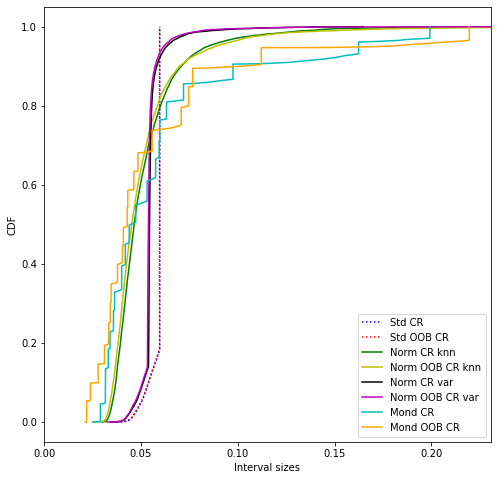

In [29]:
interval_sizes = {}
for name in prediction_intervals.keys():
    interval_sizes[name] = prediction_intervals[name][:,1] \
    - prediction_intervals[name][:,0]

plt.figure(figsize=(8,8))
plt.ylabel("CDF")
plt.xlabel("Interval sizes")
plt.xlim(0,interval_sizes["Mond OOB CR"].max()*1.05)

colors = ["b","r","g","y","k","m","c","orange"]

for i, name in enumerate(interval_sizes.keys()):
    if "Std" in name:
        style = "dotted"
    else:
        style = "solid"
    plt.plot(np.sort(interval_sizes[name]),
             [i/len(interval_sizes[name])
              for i in range(1,len(interval_sizes[name])+1)],
             linestyle=style, c=colors[i], label=name)

plt.legend()
plt.show()

Here is another view of the prediction intervals.

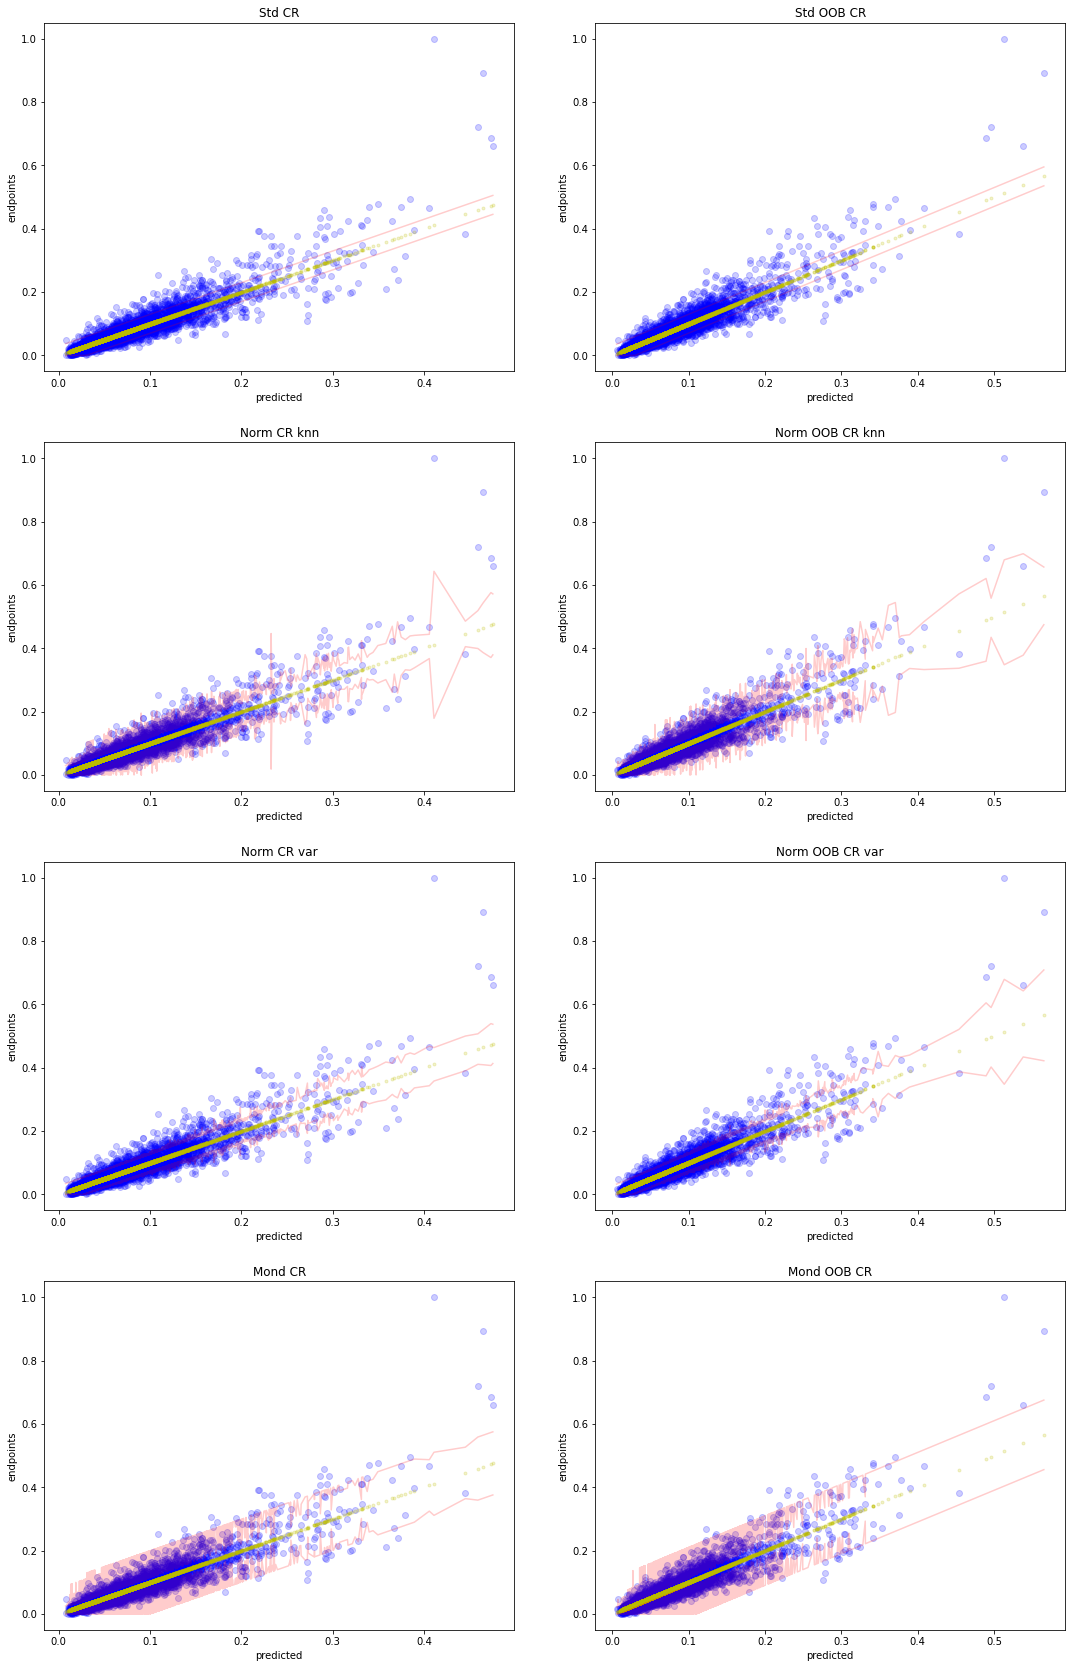

In [30]:
figure, axes = plt.subplots(4,2,figsize=(16,24))
figure.tight_layout(pad=5.0)

sorted_prop_indexes = np.argsort(y_hat_test)
sorted_full_indexes = np.argsort(y_hat_full) 

alpha=0.2
names = prediction_intervals.keys()

for i, name in enumerate(names):
    plt.subplot(4,2,i+1)
    if "OOB" in name:
        indexes = sorted_full_indexes
        y_hat = y_hat_full
    else:
        indexes = sorted_prop_indexes
        y_hat = y_hat_test

    plt.title(name)
    plt.plot(y_hat[indexes], prediction_intervals[name][indexes,0], 
             color="r", alpha=alpha)
    plt.plot(y_hat[indexes], prediction_intervals[name][indexes,1], 
             color="r", alpha=alpha)
    plt.scatter(y_hat[indexes],y_test[indexes],color="b",marker="o",
                alpha=0.2)
    plt.scatter(y_hat[indexes],y_hat[indexes],color="y",marker=".",
                alpha=0.2)
    plt.xlabel("predicted")
    plt.ylabel("endpoints")

plt.show()

#### 2.8 Evaluating the conformal regressors

Let us put six of the above conformal regressors in a dictionary

In [31]:
all_cr = {
    "Std CR":cr_std,
    "Norm CR knn":cr_norm_knn,
    "Std OOB CR":cr_std_oob,
    "Norm OOB CR knn":cr_norm_knn_oob,
    "Mond CR":cr_mond,
    "Mond OOB CR":cr_mond_oob
}

Let us evaluate them using three confidence levels on the test set.
We could specify a subset of the metrics to use by the named
`metrics` argument of the `evaluate` method; here we use all, 
which is the default.

Note that the arguments `sigmas` and `bins` can always be provided,
but they will be ignored by conformal regressors not using them,
e.g., both arguments will be ignored by the standard conformal regressors.

In [32]:
confidence_levels = [0.9,0.95,0.99]

names = list(all_cr.keys())

all_results = {}

for confidence in confidence_levels:
    for name in names:
        if "OOB" in name:
            all_results[(name,confidence)] = all_cr[name].evaluate(
                y_hat=y_hat_full, y=y_test, sigmas=sigmas_test_knn_oob,
                bins=bins_test_oob, confidence=confidence, 
                y_min=0, y_max=1)
        else:
            all_results[(name,confidence)] = all_cr[name].evaluate(
                y_hat=y_hat_test, y=y_test, sigmas=sigmas_test_knn,
                bins=bins_test, confidence=confidence, 
                y_min=0, y_max=1)

results_df = pd.DataFrame(columns=pd.MultiIndex.from_product(
    [names,confidence_levels]), index=list(list(
    all_results.values())[0].keys()))

for key in all_results.keys():
    results_df[key] = all_results[key].values()

display(results_df.round(4))

Std CR                 Norm CR knn                 Std OOB CR  \
                 0.90    0.95    0.99        0.90    0.95    0.99       0.90   
error          0.1043  0.0527  0.0093      0.1054  0.0518  0.0111     0.1067   
efficiency     0.0403  0.0585  0.1234      0.0377  0.0519  0.0942     0.0399   
time_fit       0.0002  0.0002  0.0002      0.0001  0.0001  0.0001     0.0006   
time_evaluate  0.0003  0.0001  0.0001      0.0001  0.0001  0.0001     0.0001   

                              Norm OOB CR knn                 Mond CR          \
                 0.95    0.99            0.90    0.95    0.99    0.90    0.95   
error          0.0531  0.0095          0.1019  0.0523  0.0097  0.0932  0.0473   
efficiency     0.0583  0.1191          0.0382  0.0513  0.0886  0.0428  0.0596   
time_fit       0.0006  0.0006          0.0005  0.0005  0.0005  0.0003  0.0003   
time_evaluate  0.0001  0.0001          0.0001  0.0001  0.0001  0.0006  0.0005   

                      Mond OOB CR                  
                 0.99        0.90    0.95    0.99  
error          0.0064      0.0999  0.0491  0.0085  
efficiency     0.1336      0.0419  0.0560  0.0959  
time_fit       0.0003      0.0009  0.0009  0.0009  
time_evaluate  0.0005      0.0005  0.0005  0.0005

### 3. Conformal Predictive Systems (CPS)

#### 3.1 Create and fit CPS

Let us create and fit standard and normalized conformal predictive systems, using the residuals from the calibration set (as obtained in the previous section), as well two conformal predictive systems using out-of-bag residuals; with and without normalization. As can be seen, the input for fitting conformal predictive systems is on the same format as for the conformal regressors.

In [33]:
cps_std = ConformalPredictiveSystem().fit(residuals=residuals_cal)

cps_norm = ConformalPredictiveSystem().fit(residuals=residuals_cal,
                                           sigmas=sigmas_cal_knn)

cps_std_oob = ConformalPredictiveSystem().fit(residuals=residuals_oob)

cps_norm_oob = ConformalPredictiveSystem().fit(residuals=residuals_oob, 
                                               sigmas=sigmas_oob_knn)

Let us also create some Mondrian CPS, but in contrast to the Mondrian conformal regressors above, we here form the categories through binning of the predictions rather than binning of the difficulty estimates. We may use the latter, i.e., the sigmas, to obtain a normalized CPS for each category (bin).

In [34]:
bins_cal, bin_thresholds = binning(values=y_hat_cal, bins=5)

cps_mond_std = ConformalPredictiveSystem().fit(residuals=residuals_cal,
                                                   bins=bins_cal)

cps_mond_norm = ConformalPredictiveSystem().fit(residuals=residuals_cal,
                                                    sigmas=sigmas_cal_knn,
                                                    bins=bins_cal)


bins_oob, bin_thresholds_oob = binning(values=oob_predictions, bins=5)

cps_mond_std_oob = ConformalPredictiveSystem().fit(residuals=residuals_oob,
                                                   bins=bins_oob)

cps_mond_norm_oob = ConformalPredictiveSystem().fit(residuals=residuals_oob,
                                                    sigmas=sigmas_oob_knn,
                                                    bins=bins_oob)

#### 3.2 Make predictions

For the normalized approaches, we already have the difficulty estimates which are needed for the test instances. 
For the Mondrian approaches, we also need to assign the new categories to the test instances.

In [35]:
bins_test = binning(values=y_hat_test, bins=bin_thresholds)

bins_test_oob = binning(values=y_hat_full, bins=bin_thresholds_oob)

The output of the `predict` method of a `ConformalPredictiveSystem` will depend on how we specify the input. If we provide specific target values (using the parameter `y`), the method will output a p-value for each test instance, i.e., the probability that the true target is less than or equal to the provided values. The method assumes that either one value is provided for each test instance or that the same (single) value is provided for all test instances.

Here we will obtain the p-values from `cps_mond_norm` for the true targets of the test set:

In [36]:
p_values = cps_mond_norm.predict(y_hat=y_hat_test,
                                 sigmas=sigmas_test_knn,
                                 bins=bins_test,
                                 y=y_test)

display(p_values)

array([[0.99775453],
       [0.85920772],
       [0.36033477],
       ...,
       [0.20526035],
       [0.17311994],
       [0.28119287]])

If we instead would like to get threshold values, with a specified probability that the true target is less than the threshold for each test instance, we may instead provide percentiles as input to the `predict` method. This is done through the parameter
`lower_percentiles`, which denotes (one or more) percentiles for which a lower value
will be selected in case a percentile lies between two values
(similar to `interpolation="lower"` in `numpy.percentile`), or using
`higher_percentiles`, which denotes (one or more) percentiles for which a higher value
will be selected in such cases (similar to `interpolation="higher"` in `numpy.percentile`).

Here we will obtain the lowest values from `cps_mond_norm`, such that the probability for the target values being less than these is at least 50%:

In [37]:
thresholds = cps_mond_norm.predict(y_hat=y_hat_test,
                                   sigmas=sigmas_test_knn,
                                   bins=bins_test,
                                   higher_percentiles=50)

display(thresholds)

array([[0.04015459],
       [0.02736112],
       [0.06680849],
       ...,
       [0.09347532],
       [0.0237188 ],
       [0.03262214]])

We can also specify both target values and percentiles; the resulting p-values will be returned in the first column, while any values corresponding to the lower percentiles will be included in the subsequent columns, followed by columns containing the values corresponding to the higher percentiles. The following call hence results in an array with five columns:

In [38]:
results = cps_mond_norm.predict(y_hat=y_hat_test,
                                sigmas=sigmas_test_knn,
                                bins=bins_test,
                                y=y_test,
                                lower_percentiles=[2.5, 5],
                                higher_percentiles=[95, 97.5])

display(results)

array([[0.99810429, 0.02695431, 0.02958178, 0.04900417, 0.05076842],
       [0.85815614, 0.01379118, 0.016499  , 0.03743237, 0.04150813],
       [0.35906206, 0.03367628, 0.03944166, 0.09419702, 0.10345682],
       ...,
       [0.20626713, 0.01913825, 0.03813627, 0.17666053, 0.2069551 ],
       [0.17290459, 0.0101454 , 0.01285391, 0.03379262, 0.03786942],
       [0.2825421 , 0.01490745, 0.01843349, 0.04449824, 0.04686585]])

In addition to p-values and threshold values, we can request that the `predict` method returns the full conformal predictive distribution (CPD) for each test instance, as defined by the threshold values, by setting `return_cpds=True`. The format of the distributions vary with the type of conformal predictive system; for a standard and normalized CPS, the output is an array with a row for each test instance and a column for each calibration instance (residual), while for a Mondrian CPS, the default output is a vector containing one CPD per test instance (since the number of values may vary between categories). If the desired output instead is an array of distributions per category, where all distributions in a category have the same number of columns, which in turn depends on the number of calibration instances in the corresponding category, then `cpds_by_bins=True` may be specified. In case `return_cpds=True` is specified together with `y`, `lower_percentiles` or `higher_percentiles`, the output of `predict` will be a pair, with the first element holding the results of the above type and the second element will contain the CPDs. 

For the above Mondrian CPS, the following call to `predict` will result in a vector of distributions, with one element for each test instance.

In [39]:
cpds = cps_mond_norm.predict(y_hat=y_hat_test,
                             sigmas=sigmas_test_knn,
                             bins=bins_test,
                             return_cpds=True)

print(f"No. of test instances: {len(y_hat_test)}")
print(f"Shape of cpds: {cpds.shape}")

No. of test instances: 10807
Shape of cpds: (10807,)


If we instead would prefer to represent these distributions by one array per category, we set `cpds_by_bins=True`, noting that it will be a bit trickier to associate a test instance to a specific distribution.  

In [40]:
cpds = cps_mond_norm.predict(y_hat=y_hat_test,
                             sigmas=sigmas_test_knn,
                             bins=bins_test,
                             return_cpds=True, 
                             cpds_by_bins=True)

for i, cpd in enumerate(cpds):
    print(f"bin {i}: {cpd.shape[0]} test instances, {cpd.shape[1]} threshold values")

print(f"No. of test instances: {sum([c.shape[0] for c in cpds])}")

bin 0: 2028 test instances, 541 threshold values
bin 1: 2236 test instances, 540 threshold values
bin 2: 2209 test instances, 540 threshold values
bin 3: 2152 test instances, 540 threshold values
bin 4: 2182 test instances, 541 threshold values
No. of test instances: 10807


We may also plot the conformal predictive distribution for some test object. In case the calibration set is very large, you may consider plotting an approximation of the full distribution by using a grid of values for `lower_percentiles` or `higher_percentiles`, instead of setting `return_cpds=True`. For the Mondrian CPS, the size of the calibration set for each bin is reasonable in this case, so we may just use the distributions directly.

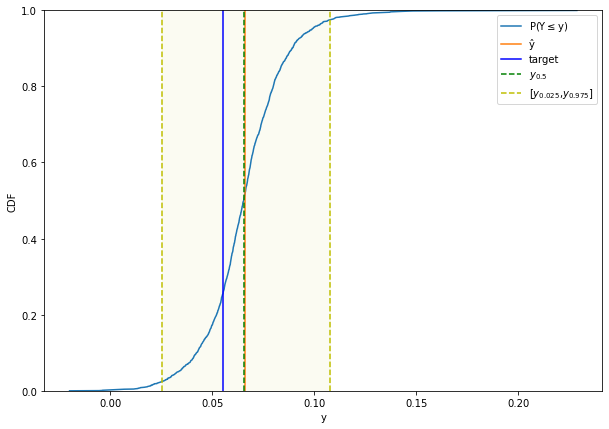

In [41]:
cpds = cps_mond_norm_oob.predict(y_hat=y_hat_full,
                                 bins=bins_test_oob,
                                 sigmas=sigmas_test_knn_oob,
                                 return_cpds=True)

test_index = np.random.randint(len(y_hat_full)) # A test object is randomly selected
cpd = cpds[test_index]

p = np.array([i/len(cpd) for i in range(len(cpd))])

lower_index = np.where(p<=0.025)[0][-1]
mid_index = np.where(p>=0.50)[0][0]
upper_index = np.where(p>=0.975)[0][0]

low_percentile = cpd[lower_index]
median = cpd[mid_index]
high_percentile = cpd[upper_index]

plt.figure(figsize=(10,7))
plt.plot(cpd,p)
plt.plot([y_hat_full[test_index],y_hat_full[test_index]],[0,1])
plt.plot([y_test[test_index],y_test[test_index]],[0,1],"b")
plt.xlabel("y")
plt.ylabel("CDF")
plt.ylim(0,1)

plt.plot([median,median],[0,1],"g--")
plt.plot([low_percentile,low_percentile],[0,1],"y--")
plt.legend(["P(Y$\leq$y)","ŷ","target","$y_{0.5}$","[$y_{0.025}$,$y_{0.975}$]"])
plt.plot([high_percentile,high_percentile],[0,1],"y--")
rectangle = plt.Rectangle((low_percentile,0),
                          abs(high_percentile-low_percentile),1, color="y", 
                          alpha=0.05)
plt.gca().add_patch(rectangle)
plt.show()

#### 3.3 Analyze the p-values

Let us put all the generated CPS in a dictionary.

In [42]:
all_cps = {"Std CPS":cps_std,
           "Std OOB CPS":cps_std_oob,
           "Norm CPS":cps_norm,
           "Norm OOB CPS":cps_norm_oob,
           "Mond CPS":cps_mond_std,
           "Mond OOB CPS":cps_mond_std_oob,
           "Mond norm CPS":cps_mond_norm,
           "Mond norm OOB CPS":cps_mond_norm_oob
          }

Now we will check if the p-values for the test targets seem to be uniformly distributed.

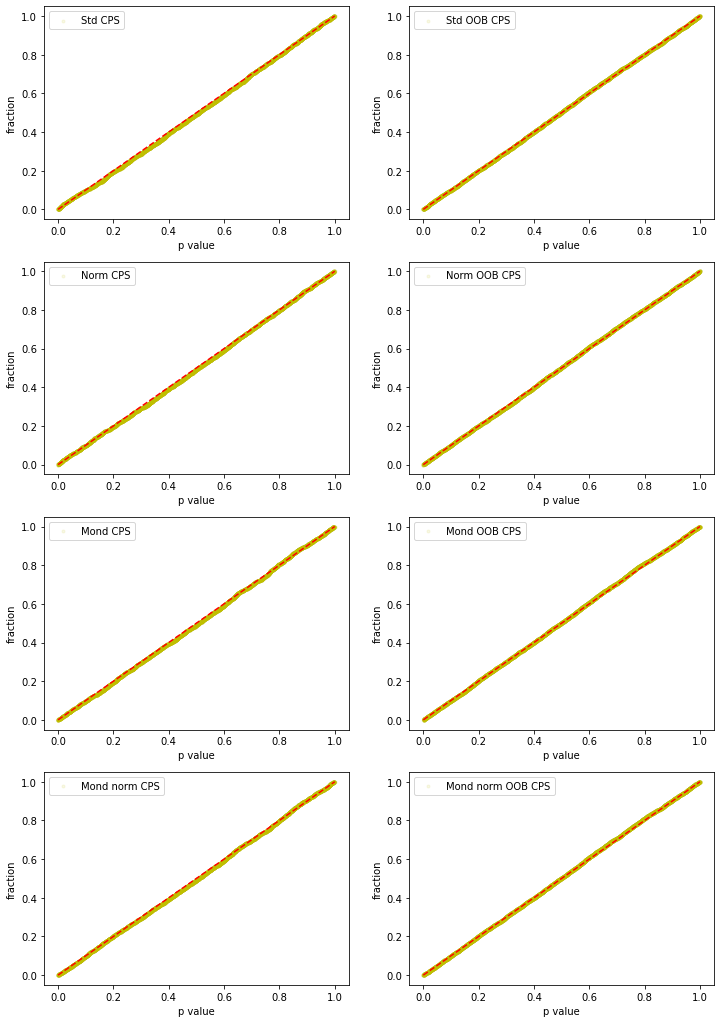

In [43]:
plt.subplots(len(all_cps.keys())//2,2,figsize=(12,18))

for i, name in enumerate(all_cps.keys()):

    if "OOB" in name:
        p_values = all_cps[name].predict(y_hat=y_hat_full, 
                                         sigmas=sigmas_test_knn_oob,
                                         bins=bins_test_oob, 
                                         y=y_test)[:,0]
    else:
        p_values = all_cps[name].predict(y_hat=y_hat, 
                                         sigmas=sigmas_test_knn, 
                                         bins=bins_test, 
                                         y=y_test)[:,0]

    plt.subplot(len(all_cps.keys())//2,2,i+1)

    plt.scatter(np.sort(p_values),
                [(i+1)/len(y_test) for i in range(len(y_test))],
                label=name, c="y", marker=".", alpha=0.1)

    plt.plot([0,1],[0,1],"r--")
    plt.legend()
    plt.ylabel("fraction")
    plt.xlabel("p value")

plt.show()

#### 3.4 Investigate the coverage and size of extracted prediction intervals

Let us investigate the extracted prediction intervals at the 95% confidence level. 
This is done by a specifying percentiles corresponding to the interval endpoints.

In [44]:
all_cps_intervals = {}

coverages = []
mean_sizes = []
median_sizes = []

for name in all_cps.keys():
    if "OOB" in name:
        intervals = all_cps[name].predict(y_hat=y_hat_full, 
                                          sigmas=sigmas_test_knn_oob, 
                                          bins=bins_test_oob,
                                          lower_percentiles=2.5, 
                                          higher_percentiles=97.5,
                                          y_min=0, y_max=1)
    else:
        intervals = all_cps[name].predict(y_hat=y_hat, 
                                          sigmas=sigmas_test_knn, 
                                          bins=bins_test,
                                          lower_percentiles=2.5, 
                                          higher_percentiles=97.5,
                                          y_min=0, y_max=1)
    all_cps_intervals[name] = intervals
    coverages.append(np.sum([1 if (y_test[i]>=intervals[i,0] and 
                                   y_test[i]<=intervals[i,1]) else 0
                            for i in range(len(y_test))])/len(y_test))
    mean_sizes.append((intervals[:,1]-intervals[:,0]).mean())
    median_sizes.append(np.median((intervals[:,1]-intervals[:,0])))

pred_int_df = pd.DataFrame({"Coverage":coverages, 
                            "Mean size":mean_sizes, 
                            "Median size":median_sizes}, 
                           index=list(all_cps_intervals.keys()))

pred_int_df.loc["Mean"] = [pred_int_df["Coverage"].mean(), 
                           pred_int_df["Mean size"].mean(),
                           pred_int_df["Median size"].mean()]

display(pred_int_df.round(4))

,Coverage,Mean size,Median size
Std CPS,0.9459,0.0616,0.0623
Std OOB CPS,0.9462,0.0598,0.0607
Norm CPS,0.9486,0.0536,0.0479
Norm OOB CPS,0.9488,0.0518,0.0457
Mond CPS,0.9522,0.0578,0.0492
Mond OOB CPS,0.9527,0.0573,0.0396
Mond norm CPS,0.9537,0.0559,0.0404
Mond norm OOB CPS,0.9548,0.0537,0.0377
Mean,0.9504,0.0564,0.0479


#### 3.5 Investigate the distributions of extracted prediction intervals

Let us take a look at the distribution of the interval sizes.

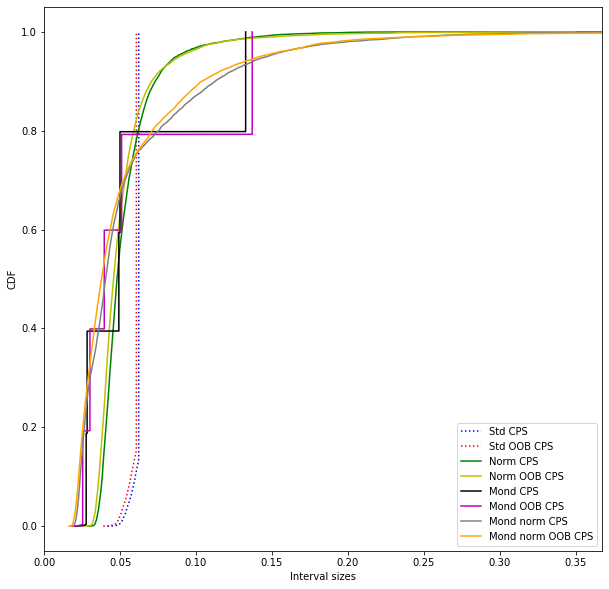

In [45]:
cps_interval_sizes = {}

for name in all_cps_intervals.keys():
    cps_interval_sizes[name] = \
    all_cps_intervals[name][:,1] - all_cps_intervals[name][:,0]

plt.figure(figsize=(10,10))
plt.ylabel("CDF")
plt.xlabel("Interval sizes")
plt.xlim(0,cps_interval_sizes["Norm OOB CPS"].max()*1.05)

colors = ["b","r","g","y","k","m", "gray", "orange"]

for i, name in enumerate(cps_interval_sizes.keys()):
    if "Std" in name:
        style = "dotted"
    else:
        style = "solid"
    plt.plot(np.sort(cps_interval_sizes[name]),
             [i/len(cps_interval_sizes[name])
              for i in range(1,len(cps_interval_sizes[name])+1)],
             linestyle=style, c=colors[i], label=name)

plt.legend()
plt.show()

#### 3.6 Extracting medians

Let us take a look at the medians; they can be derived using either lower or higher interpolation,
but ideally the differences should be small.

In [46]:
all_cps_medians = {}

for name in all_cps.keys():
    if "OOB" in name:
        medians = all_cps[name].predict(y_hat=y_hat_full, 
                                        sigmas=sigmas_test_knn_oob, 
                                        bins=bins_test_oob,
                                        lower_percentiles=50, 
                                        higher_percentiles=50)
    else:
        medians = all_cps[name].predict(y_hat=y_hat, 
                                        sigmas=sigmas_test_knn, 
                                        bins=bins_test,
                                        lower_percentiles=50, 
                                        higher_percentiles=50)
    all_cps_medians[name] = medians
    print(name)
    print("\tMean difference of the medians:    {:.6f}".format((medians[:,1]-medians[:,0]).mean()))
    print("\tLargest difference of the medians: {:.6f}".format((medians[:,1]-medians[:,0]).max()))

Std CPS
	Mean difference of the medians:    0.000000
	Largest difference of the medians: 0.000000
Std OOB CPS
	Mean difference of the medians:    0.000007
	Largest difference of the medians: 0.000007
Norm CPS
	Mean difference of the medians:    0.000000
	Largest difference of the medians: 0.000002
Norm OOB CPS
	Mean difference of the medians:    0.000003
	Largest difference of the medians: 0.000022
Mond CPS
	Mean difference of the medians:    0.000014
	Largest difference of the medians: 0.000029
Mond OOB CPS
	Mean difference of the medians:    0.000000
	Largest difference of the medians: 0.000000
Mond norm CPS
	Mean difference of the medians:    0.000021
	Largest difference of the medians: 0.000182
Mond norm OOB CPS
	Mean difference of the medians:    0.000001
	Largest difference of the medians: 0.000006


#### 3.7 Another view of the medians and prediction intervals

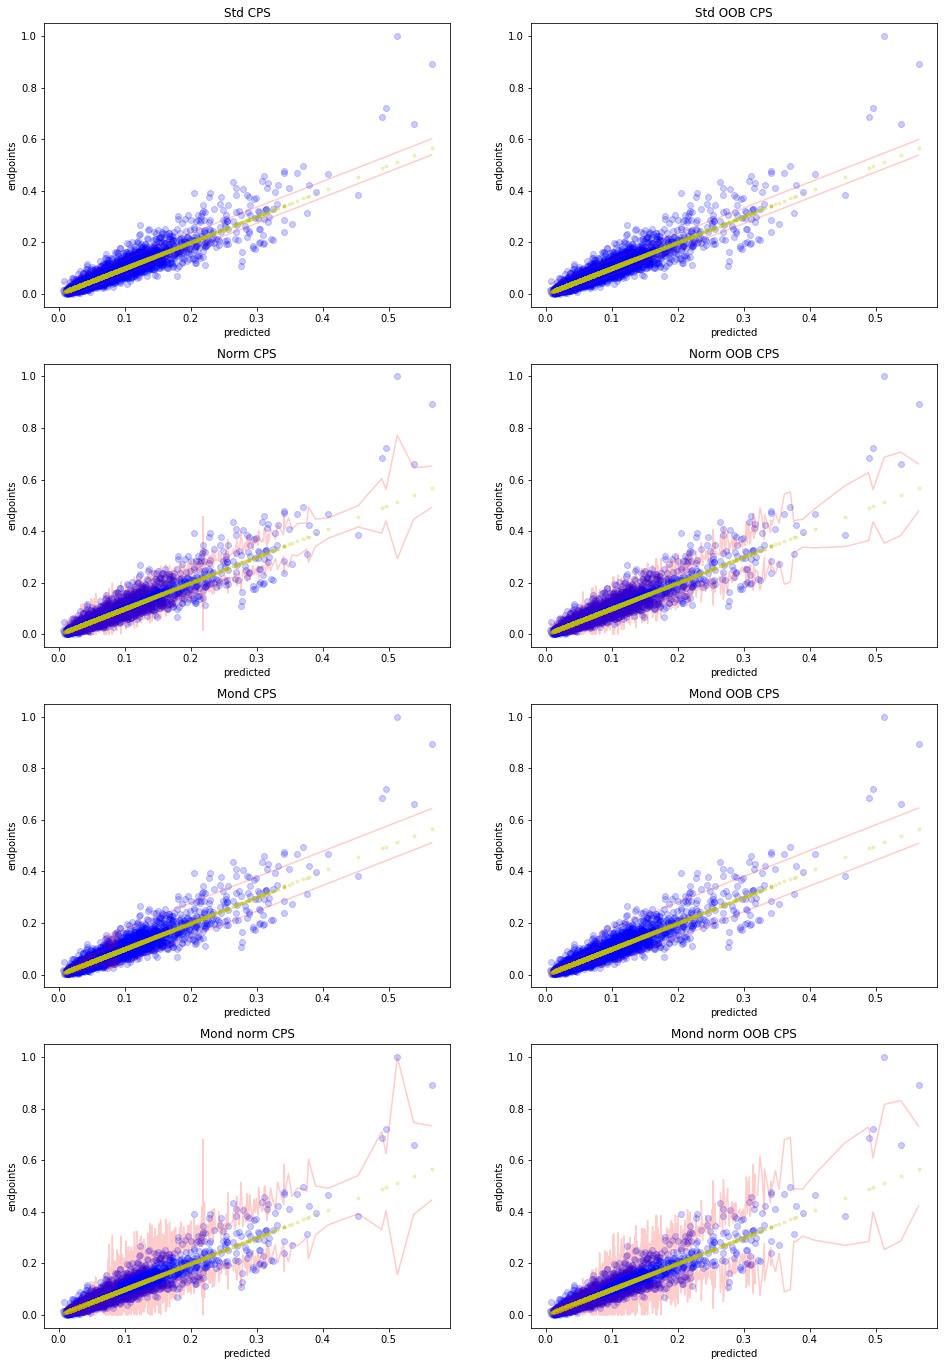

In [47]:
plt.subplots(len(all_cps_intervals.keys())//2,2,figsize=(16,24))

sorted_prop_indexes = np.argsort(y_hat) 

sorted_full_indexes = np.argsort(y_hat_full) 

alpha=0.2

for i, name in enumerate(all_cps_intervals.keys()):

    plt.subplot(len(all_cps_intervals.keys())//2,2,i+1)
    if "OOB" in name:
        indexes = sorted_full_indexes
        y_hat_ = y_hat_full
    else:
        indexes = sorted_prop_indexes
        y_hat_ = y_hat

    plt.title(name)
    plt.plot(y_hat[indexes], all_cps_intervals[name][indexes,0], 
             color="r", alpha=alpha)
    plt.plot(y_hat[indexes], all_cps_intervals[name][indexes,1], 
             color="r", alpha=alpha)
    plt.scatter(y_hat_[indexes],y_test[indexes],
                color="b", marker="o", alpha=alpha)
    plt.scatter(y_hat_[indexes],y_hat_[indexes],
                color="y", marker=".", alpha=alpha)
    plt.xlabel("predicted")
    plt.ylabel("endpoints")

plt.show()

#### 3.8 Evaluate the CPS using a test set

Let us evaluate the generated CPS using three confidence levels on the test set.
We could specify a subset of the metrics to use by the
`metrics` parameter of the `evaluate` method; here we use all metrics, 
which is the default

Note that values for the parameters `sigmas` and `bins` can always be provided,
but they will be ignored by CPS that have not been fitted with such values,
e.g., both arguments will be ignored by the standard CPS.

Note that CRPS takes some time to compute, in particular when the CPS have been fitted with 
larger calibration sets.

In [48]:
confidence_levels = [0.9,0.95,0.99]

names = np.array(list(all_cps.keys()))

first_set = names[["OOB" not in name for name in names]]
second_set = names[["OOB" in name for name in names]]

for methods in [first_set, second_set]:
    all_cps_results = {}
    for confidence in confidence_levels:
        for name in methods:
            if "OOB" in name:
                all_cps_results[(name,confidence)] = all_cps[name].evaluate(
                    y_hat=y_hat_full, y=y_test, sigmas=sigmas_test_knn_oob, 
                    bins=bins_test_oob, confidence=confidence, 
                    y_min=0, y_max=1)
            else:
                all_cps_results[(name,confidence)] =  all_cps[name].evaluate(
                    y_hat=y_hat, y=y_test, sigmas=sigmas_test_knn, 
                    bins=bins_test, confidence=confidence, y_min=0, y_max=1)

    cps_results_df = pd.DataFrame(columns=pd.MultiIndex.from_product(
        [methods,confidence_levels]), index=list(list(
        all_cps_results.values())[0].keys()))

    for key in all_cps_results.keys():
        cps_results_df[key] = all_cps_results[key].values()

    display(cps_results_df.round(4))

Std CPS                 Norm CPS                 Mond CPS  \
                 0.90    0.95    0.99     0.90    0.95    0.99     0.90   
error          0.1008  0.0541  0.0094   0.1025  0.0514  0.0092   0.1010   
efficiency     0.0423  0.0616  0.1321   0.0379  0.0536  0.1000   0.0419   
CRPS           0.0073  0.0073  0.0073   0.0070  0.0070  0.0070   0.0070   
time_fit       0.0003  0.0003  0.0003   0.0002  0.0002  0.0002   0.0002   
time_evaluate  0.4077  0.4214  0.4201   0.4030  0.4349  0.4253   0.3048   

                              Mond norm CPS                  
                 0.95    0.99          0.90    0.95    0.99  
error          0.0478  0.0049        0.0917  0.0463  0.0060  
efficiency     0.0578  0.1266        0.0424  0.0559  0.1143  
CRPS           0.0070  0.0070        0.0068  0.0068  0.0068  
time_fit       0.0002  0.0002        0.0002  0.0002  0.0002  
time_evaluate  0.3136  0.3078        0.3325  0.3148  0.3110

Std OOB CPS                 Norm OOB CPS                  \
                     0.90    0.95    0.99         0.90    0.95    0.99   
error              0.1059  0.0538  0.0100       0.1008  0.0512  0.0082   
efficiency         0.0400  0.0598  0.1253       0.0381  0.0518  0.0944   
CRPS               0.0073  0.0073  0.0073       0.0070  0.0070  0.0070   
time_fit           0.0006  0.0006  0.0006       0.0005  0.0005  0.0005   
time_evaluate      1.0001  0.8781  0.8905       0.9248  0.9094  0.9127   

              Mond OOB CPS                 Mond norm OOB CPS                  
                      0.90    0.95    0.99              0.90    0.95    0.99  
error               0.0995  0.0473  0.0086            0.0987  0.0452  0.0089  
efficiency          0.0427  0.0573  0.0994            0.0411  0.0537  0.0889  
CRPS                0.0070  0.0070  0.0070            0.0068  0.0068  0.0068  
time_fit            0.0007  0.0007  0.0007            0.0009  0.0009  0.0009  
time_evaluate       0.3966  0.3931  0.3912            0.4110  0.4066  0.4345